### If you run out of memory, execute this command and start again from the 'Load data'

In [2]:
!fuser -v /dev/nvidia* |awk '{for(i=1;i<=NF;i++)print "kill -9 " $i;}' | sh

Cannot stat file /proc/1150204/fd/0: Permission denied
Cannot stat file /proc/1150204/fd/1: Permission denied
Cannot stat file /proc/1150204/fd/2: Permission denied
Cannot stat file /proc/1150204/fd/3: Permission denied
Cannot stat file /proc/1150204/fd/4: Permission denied
Cannot stat file /proc/1150204/fd/5: Permission denied
Cannot stat file /proc/1150204/fd/8: Permission denied
Cannot stat file /proc/1150228/fd/0: Permission denied
Cannot stat file /proc/1150228/fd/1: Permission denied
Cannot stat file /proc/1150228/fd/2: Permission denied
Cannot stat file /proc/1150228/fd/3: Permission denied
Cannot stat file /proc/1150228/fd/4: Permission denied
Cannot stat file /proc/1150228/fd/5: Permission denied
Cannot stat file /proc/1150228/fd/8: Permission denied
                     USER        PID ACCESS COMMAND
/dev/nvidia-uvm:     root      mount /dev/nvidia-uvm
/dev/nvidia-uvm-tools:
                     root      mount /dev/nvidia-uvm-tools
/dev/nvidia0:        root      mount /dev/n

# Load data (From here to start)

In [3]:
import argparse
import cv2
import os
os.chdir('/remote-home/13186919777/home/STAIG-test')
from staig.adata_processing import LoadSingle10xAdata
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from multiprocessing import Pool
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from byol_pytorch import BYOL
from torchvision import models
from PIL import Image
import os
import numpy as np
import torchvision.transforms as T
import random
from torch import nn
import time
import scanpy as sc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans






data_dir = '/remote-home/13186919777/home/STAIG-test/Dataset/visium/Human_Breast_Cancer'

/opt/miniconda3/envs/STAIG/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Clip to patches

In [2]:
path = data_dir
label=True
d=288
patch_size = int(3.5*d)
# Initialize data loader
loader = LoadSingle10xAdata(path=path, image_emb=False, label=label, filter_na=True)
loader.load_data()
if label:
    loader.load_label()
adata = loader.adata

if os.path.exists(os.path.join(path, "spatial", "tissue_full_image.tif")):
    print("File exists.")
else:
    print("File does not exist.")


# Read tiff image
im = cv2.imread(os.path.join(path, "spatial", "tissue_full_image.tif"), cv2.IMREAD_COLOR)
# Create directory for clipped images
clip_image_path = os.path.join(path, 'clip_image')
try:
    os.makedirs(clip_image_path)
    print("Folder 'clip_image' created successfully")
except FileExistsError:
    print("Folder 'clip_image' already exist")

# Process and save patches
patches = []
for i, coord in tqdm(enumerate(adata.obsm['spatial']), total=len(adata.obsm['spatial'])):
    # Calculate patch coordinates
    left = int(coord[0] - patch_size / 2)
    top = int(coord[1] - patch_size / 2)
    right = left + patch_size
    bottom = top + patch_size

    # Extract patch
    patch = im[top:bottom, left:right]

    # Resize patch to 512x512, using INTER_LINEAR for both upsizing and downsizing
    if patch_size != 512:
        resized_patch = cv2.resize(patch, (512, 512), interpolation=cv2.INTER_LINEAR)
    else:
        resized_patch = patch
    # Save resized patch
    cv2.imwrite(os.path.join(clip_image_path, f'{i}.png'), resized_patch)


File exists.
Folder 'clip_image' already exist


100%|███████████████████████████████████████| 3798/3798 [05:01<00:00, 12.59it/s]


# 2. Filter patches

In [3]:
def process_image(filename, path, output_path, GaussianBlur, lower, upper):
    image_path = os.path.join(path, filename)
    image = cv2.imread(image_path, 0)
    original_height, original_width = image.shape[:2]

    resize_needed = (original_height != 512 or original_width != 512)
    if resize_needed:
        image = cv2.resize(image, (512, 512))

    if GaussianBlur:
        image = cv2.GaussianBlur(image, (5, 5), 0)

    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    image_shape = image.shape
    custom_mask = create_custom_mask(image_shape, lower, lower, upper, upper)
    fshift_masked = fshift * custom_mask
    f_ishift = np.fft.ifftshift(fshift_masked)
    image_filtered = np.fft.ifft2(f_ishift)
    image_filtered = np.abs(image_filtered)
    if GaussianBlur:
        image_filtered = cv2.GaussianBlur(image_filtered, (15, 15), 0)
    image_filtered_rgb = cv2.cvtColor(np.float32(image_filtered), cv2.COLOR_GRAY2RGB)
    mae_patch = cv2.resize(image_filtered_rgb, (224, 224), interpolation=cv2.INTER_LINEAR)

    if resize_needed:
        image_filtered_rgb = cv2.resize(image_filtered_rgb, (original_width, original_height))
    cv2.imwrite(os.path.join(output_path, filename), image_filtered_rgb)
    return mae_patch

def create_custom_mask(image_shape, x1, y1, x2, y2):
    rows, cols = image_shape
    mask = np.zeros((rows, cols), np.uint8)
    mask[y1:y2, x1:x2] = 1
    return mask


path = os.path.join(data_dir,'clip_image')
output_path =  os.path.join(data_dir,'clip_image_filter')
GaussianBlur = True
upper = 275
lower = 245

try:
    os.makedirs(output_path)
    print("Folder 'clip_image_filter' created successfully")
except FileExistsError:
    print("Folder 'clip_image_filter' already exist")

png_files = [name for name in os.listdir(path) if name.endswith('.png')]
args = [(filename, path, output_path, GaussianBlur, lower, upper) for filename in png_files]

with Pool(processes=os.cpu_count()) as pool:
    patches = pool.starmap(process_image, args)


Folder 'clip_image_filter' already exist


# 3. BYOL

In [4]:
def process_images(dataset_name, slide, epoch_num):
    path = f"./Dataset/{dataset_name}/{slide}/clip_image_filter"

    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.cuda.manual_seed_all(42)
    random.seed(42)
    np.random.seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8' 
    torch.use_deterministic_algorithms(True)

    class CustomDataset(Dataset):
        def __init__(self, root_dir, transform=None):
            self.root_dir = root_dir
            self.transform = transform
            self.image_list = sorted(
                [x for x in os.listdir(root_dir) if x.endswith('.png')],
                key=lambda x: int(x.split('.')[0])
                )


        def __len__(self):
            return len(self.image_list)

        def __getitem__(self, idx):
            img_name = os.path.join(self.root_dir, self.image_list[idx])
            img = Image.open(img_name).convert('RGB')

            if self.transform:
                img = self.transform(img)

            return img

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])

    dataset = CustomDataset(path, transform=transform)
    data_loader = DataLoader(dataset, batch_size=28, shuffle=True, num_workers=1) 

    class RandomApply(nn.Module):
        def __init__(self, fn, p):
            super().__init__()
            self.fn = fn
            self.p = p

        def forward(self, x):
            if random.random() > self.p:
                return x
            return self.fn(x)

    DEFAULT_AUG = torch.nn.Sequential(
        RandomApply(
            T.ColorJitter(0.8, 0.8, 0.8, 0.2),
            p=0.3
        ),
        T.RandomGrayscale(p=0.2),
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        RandomApply(
            T.GaussianBlur((3, 3), (1.0, 2.0)),
            p=0.2
        ),
        T.RandomRotation(degrees=(0, 360)),
        T.RandomResizedCrop((256, 256)),
        T.Normalize(
            mean=torch.tensor([0.485, 0.456, 0.406]),
            std=torch.tensor([0.229, 0.224, 0.225])),

    )

    learner = BYOL(
            models.resnet50(pretrained=True),
            image_size=256,
            hidden_layer='avgpool',
            augment_fn=DEFAULT_AUG
        )
    if torch.cuda.is_available():
        learner = learner.cuda()

    opt = torch.optim.Adam(learner.parameters(), lr=3e-4)

    print('start training!')
    for epoch in range(epoch_num):
        start_time = time.time()
        for images in data_loader:
            images = images.cuda() if torch.cuda.is_available() else images
            loss = learner(images)
            opt.zero_grad()
            loss.backward()
            opt.step()
            learner.update_moving_average()
        end_time = time.time()
        print(f'Epoch [{epoch + 1}/{epoch_num}], Loss: {loss.item():.4f}, Time: {end_time - start_time:.2f} seconds')

    torch.save(learner.state_dict(), 'learner.pth')

    learner.eval()
    embeddings = []
    print('start eval!')
    for i in tqdm(range(len(dataset)), desc='Evaluation Progress'):
        img = dataset[i]
        img = img.cuda() if torch.cuda.is_available() else img
        with torch.no_grad():
            _, embedding = learner(img.unsqueeze(0), return_embedding=True)
            embeddings.append(embedding.cpu().numpy())

    embeddings = np.vstack(embeddings)
    np.save(f'./Dataset/{dataset_name}/{slide}/embeddings.npy', embeddings)
    print(embeddings.shape)

epoch_num=3
dataset = 'visium'
slide = 'Human_Breast_Cancer'
process_images(dataset, slide, epoch_num)

start training!
Epoch [1/3], Loss: 0.3634, Time: 101.74 seconds
Epoch [2/3], Loss: 0.2640, Time: 63.21 seconds
Epoch [3/3], Loss: 0.4853, Time: 48.86 seconds
start eval!


Evaluation Progress: 100%|██████████| 3798/3798 [01:53<00:00, 33.47it/s]


(3798, 2048)


# 4. Show the image embeddings

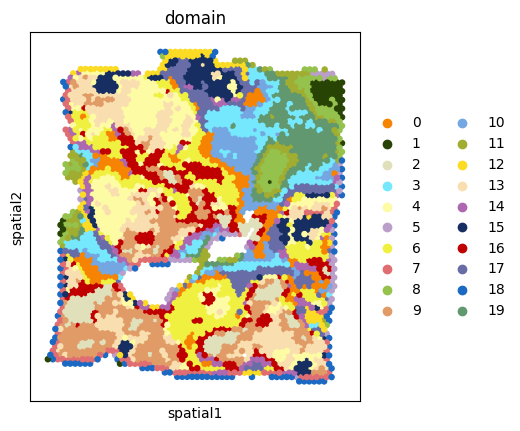

In [5]:
def show_emb(dataset, slide, n_clusters, label):
    # Generate dataset path
    path = f"./Dataset/{dataset}/{slide}"

    # Initialize data loader
    loader = LoadSingle10xAdata(path=path, image_emb=False, label=label, filter_na=True)
    loader.load_data()
    if label:
        loader.load_label()
    adata = loader.adata

    # Load embeddings
    data = np.load(os.path.join(path, 'embeddings.npy'))
    data = data.reshape(data.shape[0], -1)

    # Standardize and apply PCA
    scaler = StandardScaler()
    embedding = scaler.fit_transform(data)
    pca = PCA(n_components=128, random_state=42)
    embedding = pca.fit_transform(embedding)
    adata.obsm['emb'] = embedding

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(adata.obsm['emb'].copy())
    labels_str = [str(label) for label in labels]
    adata.obs['domain'] = labels_str

    color_map= {'19': '#619870',
        '5':'#ba9fca' ,
        '15': '#162e62',
        '10': '#74A6E2',
        '11': '#A0ad30',
        '12': '#fbdb24',
        '0':'#f68402',
        '16': '#C00000',
        '2': '#E0E0BB',
        '13': '#f9dfaf',
        '6': '#f0f040',
        '14': '#ae68b0',
        '7': '#E06D71',
        '1':'#284405' ,
        '17': '#686da7',
        '8': '#95c14d',
        '4': '#fdfba4',
        '3': '#75e8fd',
        '9': '#E19B67',
        '18': '#1B69C3'
        }
    # Plot spatial image with clusters
    sc.pl.spatial(adata, img_key=None,size=2, color=["domain"], show=True,palette=color_map,save='HBCimg.pdf')
dataset = 'visium'
slide = 'Human_Breast_Cancer'
n_clusters=20
show_emb(dataset, slide, n_clusters, label=True)
